In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [6]:
DATA_DIR = 'dataset/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [7]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

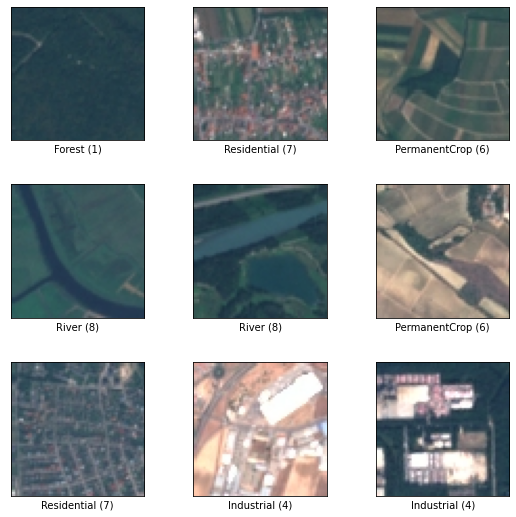

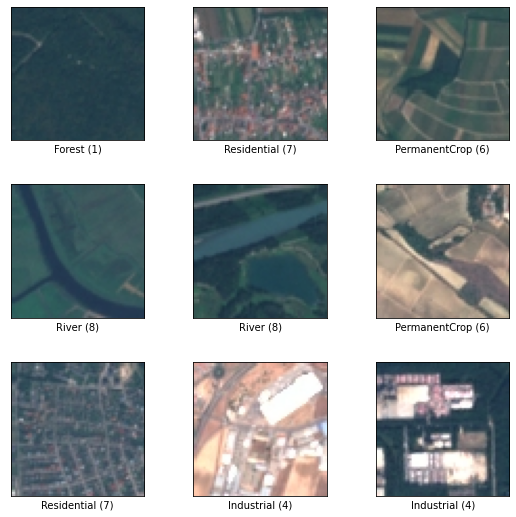

In [8]:
tfds.show_examples(train_ds, info)

,image,label
0,,8 (River)
1,,9 (SeaLake)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,2 (HerbaceousVegetation)
9,,0 (AnnualCrop)

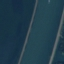
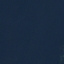
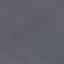
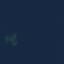
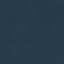
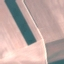
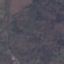
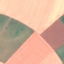
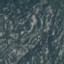
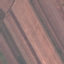

In [9]:
tfds.as_dataframe(valid_ds.take(10), info)

In [10]:
NUM_CLASS = info.features['label'].num_classes
print(NUM_CLASS)

10


In [13]:
print(info.features['label'].int2str(9))

SeaLake


In [14]:
# 데이터 전처리
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255.
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [15]:
def build_model():
  model = tf.keras.Sequential([
                               #Convolution
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                               tf.keras.layers.MaxPool2D((2, 2)),

                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
                               tf.keras.layers.MaxPool2D((2, 2)),

                               #Classifier
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(128, activation='relu'),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(64, activation='relu'),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(NUM_CLASS, activation='softmax')

  ])
  return model
model = build_model()

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=valid_data, epochs=50)

Epoch 1/50
338/338 [==============================] - 39s 22ms/step - loss: 1.6907 - accuracy: 0.3984 - val_loss: 1.7965 - val_accuracy: 0.4007
Epoch 2/50
338/338 [==============================] - 7s 19ms/step - loss: 1.3171 - accuracy: 0.5283 - val_loss: 0.9286 - val_accuracy: 0.7189
Epoch 3/50
338/338 [==============================] - 7s 19ms/step - loss: 1.1292 - accuracy: 0.5966 - val_loss: 0.8952 - val_accuracy: 0.6972
Epoch 4/50
338/338 [==============================] - 7s 20ms/step - loss: 1.0019 - accuracy: 0.6432 - val_loss: 0.8872 - val_accuracy: 0.7200
Epoch 5/50
338/338 [==============================] - 7s 20ms/step - loss: 0.8991 - accuracy: 0.6869 - val_loss: 0.7136 - val_accuracy: 0.7598
Epoch 6/50
338/338 [==============================] - 7s 20ms/step - loss: 0.8016 - accuracy: 0.7241 - val_loss: 0.5686 - val_accuracy: 0.8174
Epoch 7/50
338/338 [==============================] - 7s 19ms/step - loss: 0.7224 - accuracy: 0.7534 - val_loss: 0.5432 - val_accuracy: 0.836

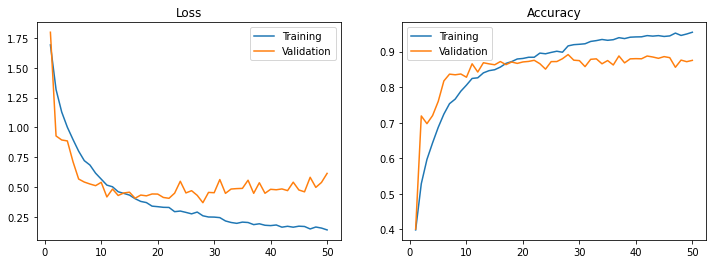

In [20]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].plot(range(1, epoch + 1), loss, label='Training')
  axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')
  axes[1].plot(range(1, epoch + 1), acc, label='Training')
  axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')
  plt.show()
plot_loss_acc(history, 50)

Text(0.5, 1.0, 'River')

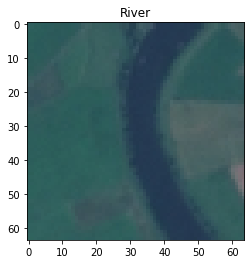

In [21]:
# Data Augmentation
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()
plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [22]:
# 데이터 증감 전후 비교 시각화 함수
def plot_augmentation(original, augmented):
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].imshow(original)
  axes[0].set_title('Original')
  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')
  plt.show()

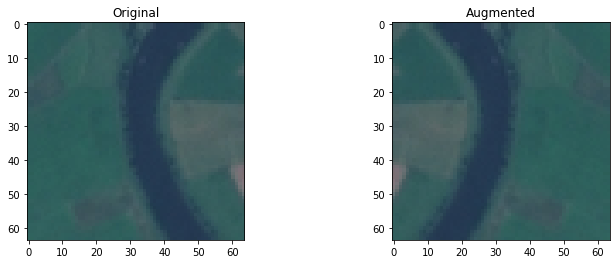

In [23]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

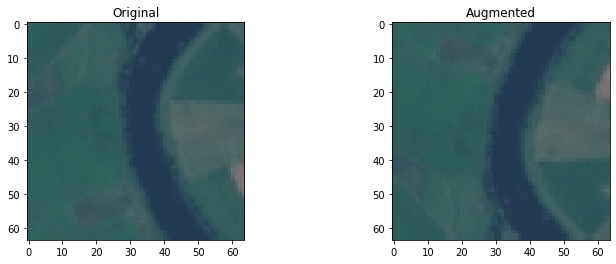

In [24]:
# 상하 뒤집기
up_flip = tf.image.flip_up_down(image)
plot_augmentation(image, up_flip)

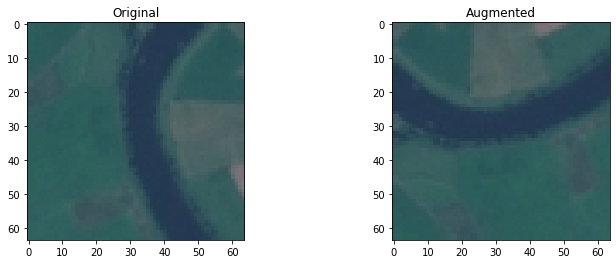

In [25]:
# 회전
rotat90 = tf.image.rot90(image)
plot_augmentation(image, rotat90)

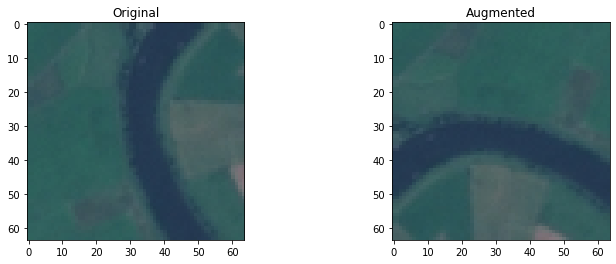

In [26]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

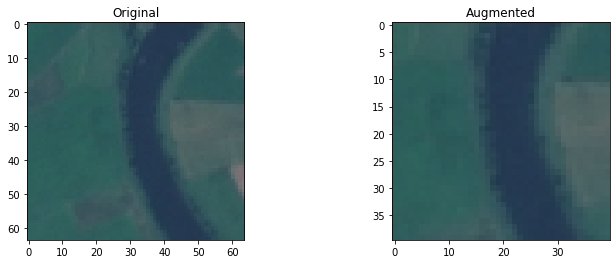

In [27]:
# 이미지 자르기1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

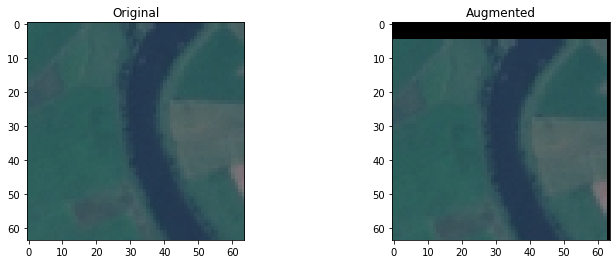

In [28]:
#이미지 자르기2
crop2 = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(crop2, size=[64, 64, 3])
plot_augmentation(image, crop2)

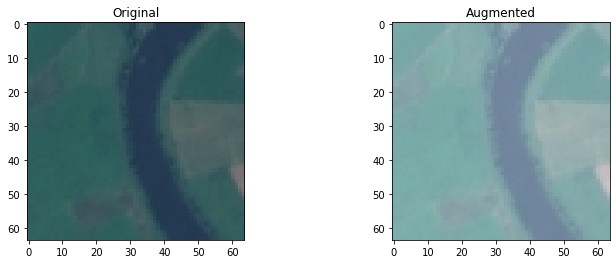

In [29]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

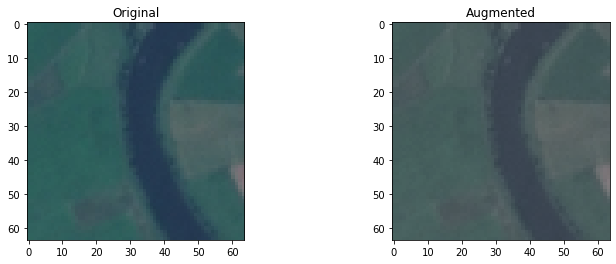

In [31]:
# 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

In [32]:
# 증강 전처리 함수
def data_augmentation(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.3)
  image = tf.image.random_crop(image, size=[64, 64, 3])
  image = tf.cast(image, tf.float32) / 255.
  return image, label

In [33]:
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
aug_model = build_model()
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 10s 26ms/step - loss: 1.8761 - accuracy: 0.3043 - val_loss: 1.6446 - val_accuracy: 0.4083
Epoch 2/50
338/338 [==============================] - 8s 23ms/step - loss: 1.5755 - accuracy: 0.3944 - val_loss: 1.4860 - val_accuracy: 0.4519
Epoch 3/50
338/338 [==============================] - 8s 24ms/step - loss: 1.4446 - accuracy: 0.4467 - val_loss: 1.2172 - val_accuracy: 0.5715
Epoch 4/50
338/338 [==============================] - 9s 25ms/step - loss: 1.3104 - accuracy: 0.5036 - val_loss: 1.0540 - val_accuracy: 0.6239
Epoch 5/50
338/338 [==============================] - 9s 25ms/step - loss: 1.2368 - accuracy: 0.5381 - val_loss: 1.0566 - val_accuracy: 0.6198
Epoch 6/50
338/338 [==============================] - 8s 22ms/step - loss: 1.1841 - accuracy: 0.5562 - val_loss: 1.0314 - val_accuracy: 0.6665
Epoch 7/50
338/338 [==============================] - 8s 22ms/step - loss: 1.1384 - accuracy: 0.5804 - val_loss: 0.9068 - val_accuracy: 0.674

In [ ]:
plot_loss_acc(aug_history, 50)